In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, LSTM,Bidirectional,Attention,Concatenate
from tensorflow.keras import regularizers, optimizers,losses
from tensorflow.keras.metrics import Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives, SpecificityAtSensitivity,SensitivityAtSpecificity
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.utils import np_utils
import numpy as np
import pandas as pd 
import matplotlib
import seaborn as sns
import sklearn

from imblearn.over_sampling import RandomOverSampler 
import imblearn
import matplotlib.pyplot as plt
import time
import os
import sklearn.metrics as m
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import skimage.io
import skimage.color
import skimage.filters

In [71]:
import pandas as pd
data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
print(data.shape,tabular_data.shape)

(10015, 2353) (10015, 7)


In [72]:
#classes = {'mel':0 ,'vasc':1,'df':2,'nv':3,'bkl':4,'bcc':5,'ak':6}
classes = {4: ('nv',' melanocytic nevi'),
           6: ('mel','melanoma'),
           2:('bkl','benign keratosis-like lesions'),
           1: ('bcc',' basal cell carcinoma'),
           5: ('vasc',' pyogenic granulomas and hemorrhage'),
           0: ('akiec','Actinic keratoses and intraepithelial carcinomae'),
           3: ('df','dermatofibroma')}

Text(0.5, 1.0, 'Frequency Distribution of Classes')

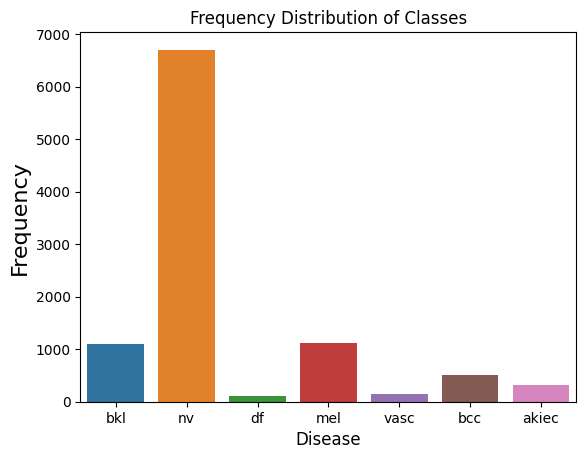

In [73]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=16)
plt.title('Frequency Distribution of Classes', size=12)

### Oversampling

In [74]:
y = data['label']
x = data.drop(columns = ['label'])

oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

y = to_categorical(y)
x= np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (46935, 28, 28, 3)


### Standardization & Data Splitting

In [75]:
x = (x-np.mean(x))/np.std(x)

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)
print(X_train.shape , X_test.shape)
print(Y_train.shape , Y_test.shape)

(37548, 28, 28, 3) (9387, 28, 28, 3)
(37548, 7) (9387, 7)


### Resize Image Here

In [76]:
import tensorflow as tf

IMAGE_SIZE = 64  

X_train_resized = tf.image.resize(X_train, (IMAGE_SIZE, IMAGE_SIZE))
X_test_resized = tf.image.resize(X_test, (IMAGE_SIZE, IMAGE_SIZE))

print(X_train_resized.shape, X_test_resized.shape)


(37548, 64, 64, 3) (9387, 64, 64, 3)


### Model

In [77]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

Name = "DN201"

densenet_base = DenseNet201(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in densenet_base.layers:
    layer.trainable = True

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

densenet_output = densenet_base(input_layer)
x = GlobalAveragePooling2D()(densenet_output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=predictions)
model.summary()


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 2, 2, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         245,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,568,775 (70.83 MB)

 Trainable params: 18,339,719 (69.96 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [79]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [80]:
model.compile(optimizer= keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy() ,
              metrics=['acc',Recall(),Precision(),AUC(),TruePositives(),TrueNegatives(),FalseNegatives(),FalsePositives()])


history = model.fit(X_train_resized, Y_train, epochs=100, validation_data=(X_test_resized, Y_test), batch_size=128, callbacks=[callback])

Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - acc: 0.6923 - auc_3: 0.9255 - false_negatives_3: 6267.8501 - false_positives_3: 2473.8708 - loss: 0.8929 - precision_3: 0.7919 - recall_3: 0.5944 - true_negatives_3: 110804.4141 - true_positives_3: 12611.8643
Epoch 1: saving model to best_model.keras
294/294 ━━━━━━━━━━━━━━━━━━━━ 585s 945ms/step - acc: 0.6926 - auc_3: 0.9257 - false_negatives_3: 6280.0205 - false_positives_3: 2480.5220 - loss: 0.8919 - precision_3: 0.7921 - recall_3: 0.5949 - true_negatives_3: 111177.4609 - true_positives_3: 12662.9766 - val_acc: 0.7687 - val_auc_3: 0.9422 - val_false_negatives_3: 2403.0000 - val_false_positives_3: 1804.0000 - val_loss: 0.9985 - val_precision_3: 0.7947 - val_recall_3: 0.7440 - val_true_negatives_3: 54518.0000 - val_true_positives_3: 6984.0000
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - acc: 0.8963 - auc_3: 0.9911 - false_negatives_3: 2205.1768 - false_positives_3: 1458.1361 - loss: 0.2946 - precision_3: 0.9169 - recal

### Saving the model

In [81]:
model.save(Name+'.h5')

pd.DataFrame.from_dict(history.history).to_csv(Name+'.csv',index=False)

### Accuracy Curve

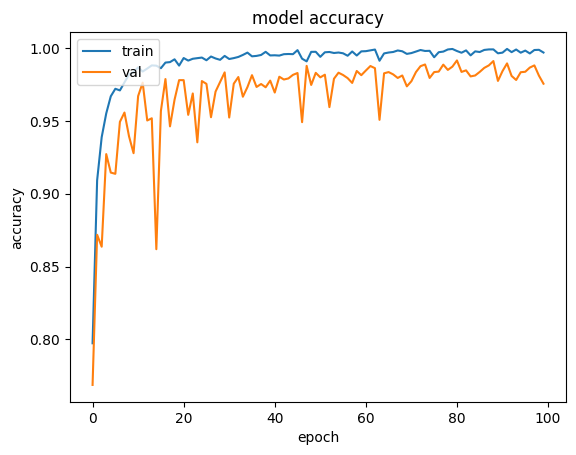

In [82]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Loss Curve

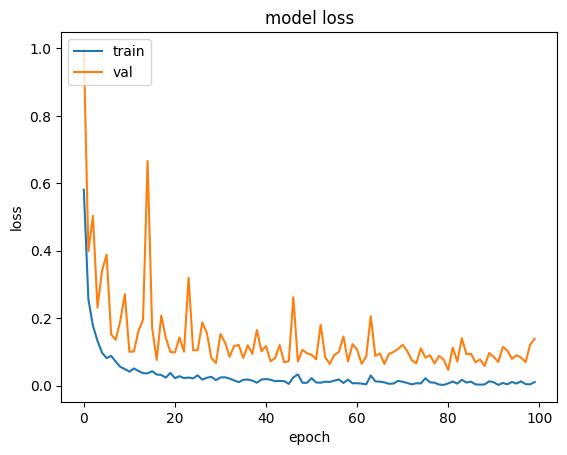

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
res = model.evaluate(X_test_resized, Y_test, verbose=1)
print(res)

294/294 ━━━━━━━━━━━━━━━━━━━━ 43s 90ms/step - acc: 0.9739 - auc_3: 0.9943 - false_negatives_3: 119.1119 - false_positives_3: 116.9119 - loss: 0.1423 - precision_3: 0.9740 - recall_3: 0.9734 - true_negatives_3: 28297.5840 - true_positives_3: 4616.6372
[0.138750821352005, 0.9756045341491699, 0.9753915071487427, 0.9759113192558289, 0.9946659803390503, 9156.0, 56096.0, 231.0, 226.0]


294/294 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step


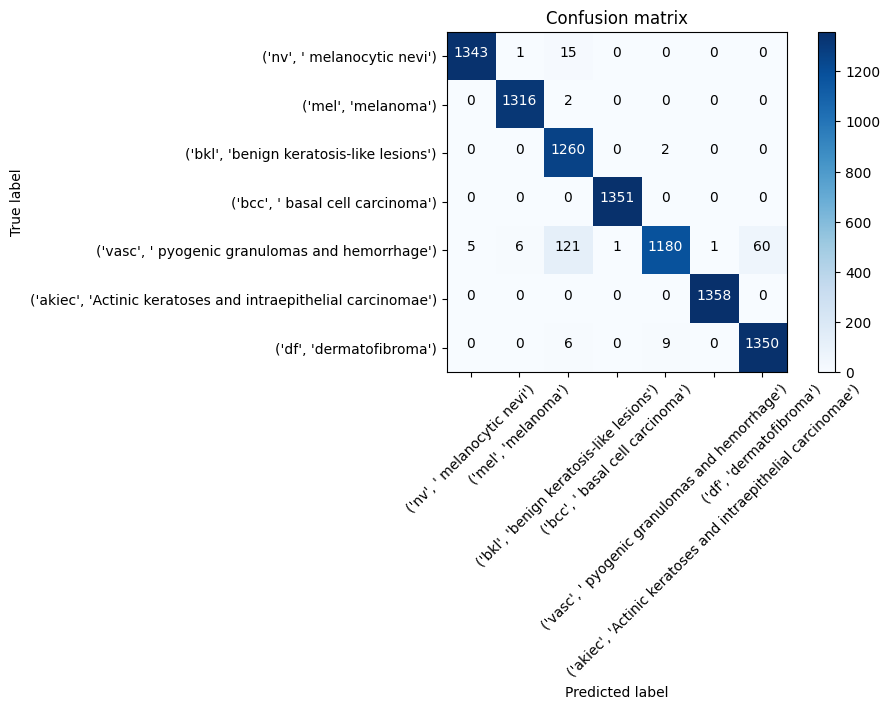

In [85]:
import itertools
from sklearn.metrics import confusion_matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots(figsize = (10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test_resized)

Y_pred_classes = np.argmax(Y_pred,axis = 1) 

confusion_mtx = confusion_matrix(np.argmax(Y_test,axis=1), Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes.values()) 

### Report 

In [86]:
from sklearn.metrics import classification_report
import numpy as np

Y_pred = np.argmax(model.predict(X_test_resized), axis=1)
print('Classification Report')
print(classification_report(np.float32(np.argmax(Y_test, axis=1)), Y_pred.round(), digits=4))

294/294 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Classification Report
              precision    recall  f1-score   support

         0.0     0.9963    0.9882    0.9922      1359
         1.0     0.9947    0.9985    0.9966      1318
         2.0     0.8974    0.9984    0.9452      1262
         3.0     0.9993    1.0000    0.9996      1351
         4.0     0.9908    0.8588    0.9201      1374
         5.0     0.9993    1.0000    0.9996      1358
         6.0     0.9574    0.9890    0.9730      1365

    accuracy                         0.9756      9387
   macro avg     0.9765    0.9761    0.9752      9387
weighted avg     0.9772    0.9756    0.9753      9387

